# KAN预测      ---2024.7.17

In [1]:
from kan import *
import matplotlib.pyplot as plt
from efficient_kan import EfficientKAN

In [2]:
def figure(f, model_kan, model_efficient_kan, ranges_train=[-1, 1], ranges_test=(-1.5, 1.5)):
    # 创建网格数据
    x = np.linspace(ranges_test[0], ranges_test[1], 100)
    y = np.linspace(ranges_test[0], ranges_test[1], 100)
    X_grid, Y_grid = np.meshgrid(x, y)

    # 计算每个网格点的输出值 Z
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    Z1 = f(grid_points_torch).numpy().reshape(X_grid.shape)
    Z2 = model_kan(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_efficient_kan(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)

    # 根据范围计算正方形的顶点坐标
    square_vertices = [(ranges_train[1], ranges_train[1]), (ranges_train[0], ranges_train[1]),
                   (ranges_train[0], ranges_train[0]), (ranges_train[1], ranges_train[0]),
                   (ranges_train[1], ranges_train[1])]
    x_square, y_square = zip(*square_vertices)
    
    # 绘制等高线图
    font_size = 18
    plt.rcParams['font.size'] = 18
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    # 绘制等高线图1 (Z1)
    contour1 = ax1.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
#     ax1.set_xlabel('a')
#     ax1.set_ylabel('b')
    ax1.set_title('True')
    ax1.plot(x_square, y_square, 'r-')
    # 绘制等高线图2 (Z2)
    contour2 = ax2.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
#     ax2.set_xlabel('a')
#     ax2.set_ylabel('b')
    ax2.set_title('KAN')
    ax2.plot(x_square, y_square, 'r-')
    # 绘制等高线图3 (Z3)
    contour3 = ax3.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
#     ax3.set_xlabel('a')
#     ax3.set_ylabel('b')
    ax3.set_title('efficient-KAN')
    ax3.plot(x_square, y_square, 'r-')
    # 添加一个共享的颜色条
    cbar = fig.colorbar(contour2, ax=[ax1, ax2, ax3], location='right', shrink=1)
    plt.show()

In [3]:
def train_efficient_kan(dataset, model):
    with tqdm(range(40)) as pbar:
        for i in pbar:
            loss, reg_loss = None, None
            def closure():
                optimizer.zero_grad()
                y = model(dataset['train_input'])

                nonlocal loss, reg_loss
                loss = nn.functional.mse_loss(y, dataset['train_label'])
                reg_loss = model.regularization_loss(1, 0)
                (loss + 1e-5 * reg_loss).backward()
                return loss + reg_loss
            optimizer.step(closure)
            loss_test = nn.functional.mse_loss(model(dataset['test_input']), dataset['test_label'])
            pbar.set_postfix(mse_train_loss=loss.item(), test_loss=loss_test.item(), reg_loss=reg_loss.item())

# 1.f=e^(sin(pi*x)+y^2)

In [4]:
# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:, [0]]) + x[:, [1]]**2)
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [5]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 1, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 1.48e-02 | test loss: 1.52e-02 | reg: 2.99e+00 : 100%|██| 20/20 [00:06<00:00,  3.31it/s]


In [6]:
# initialize efficientKAN # 结果的波动性很大，经常出现nan
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:23<00:00,  1.73it/s, mse_train_loss=0.00471, reg_loss=4, test_loss=0.0049


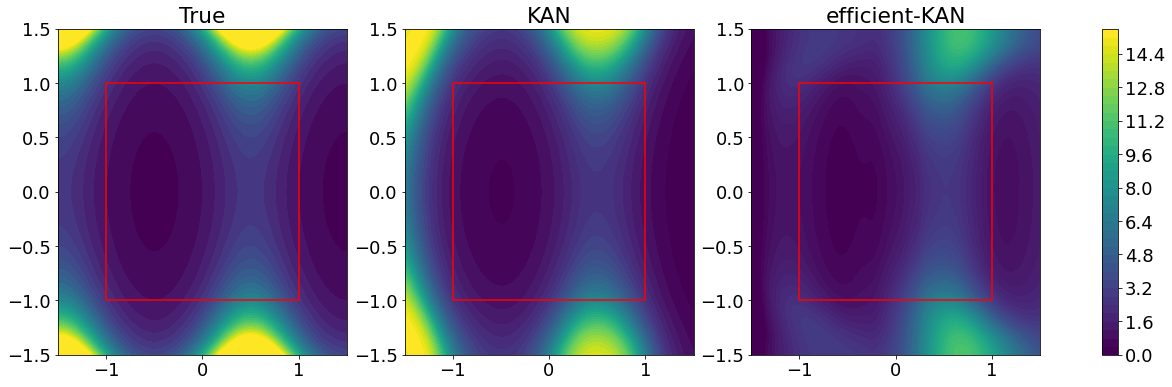

In [7]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 2.f=e(-(x^2)/(2*y^2))/sqrt(2*pi*y^2)

In [8]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: torch.exp(-(x[:, [0]]**2)/(2*x[:, [1]]**2))/torch.sqrt(2*torch.pi*x[:, [1]]**2)
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [9]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 2, 1, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 9.52e-01 | test loss: 1.52e+00 | reg: 5.33e+00 : 100%|██| 20/20 [00:10<00:00,  1.96it/s]


In [14]:
# initialize efficientKAN # always NAN
model_efficient_kan = EfficientKAN([2, 2, 1, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|██| 40/40 [00:25<00:00,  1.55it/s, mse_train_loss=1.28, reg_loss=20.8, test_loss=2.62]


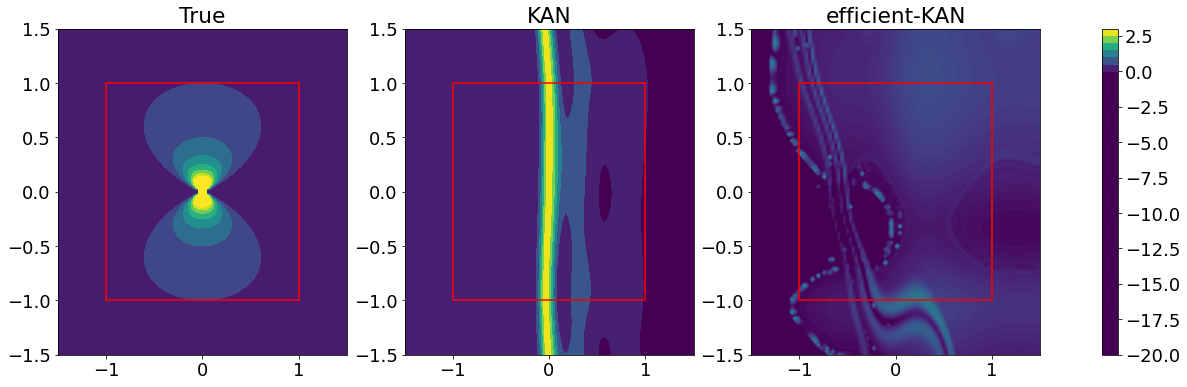

In [15]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 3.f=(1+ab) /(1+a)

In [16]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: (1+x[:, [0]]*x[:, [1]])/(1+x[:, [0]])
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [17]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 2, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 1.31e+02 | test loss: 2.39e+02 | reg: 1.70e+02 : 100%|██| 20/20 [00:09<00:00,  2.03it/s]


In [18]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:22<00:00,  1.76it/s, mse_train_loss=1.5e+5, reg_loss=45.6, test_loss=2.63


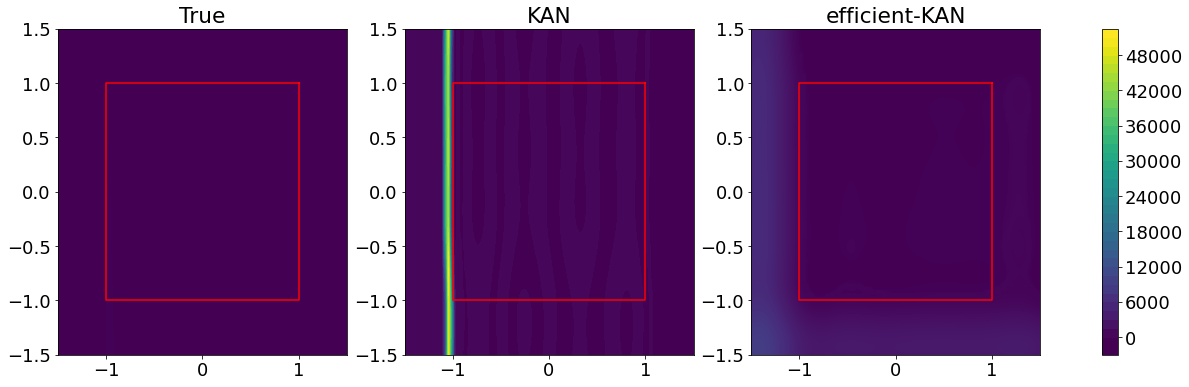

In [19]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 4. f=arcsin(a*sinb)

In [20]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: torch.arcsin(x[:, [0]]*torch.sin(x[:, [1]]))
# define Training data range
ranges_train = (-0.6, 0.6)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [21]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 2, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 1.05e-03 | test loss: 1.10e-03 | reg: 6.82e+00 : 100%|██| 20/20 [00:09<00:00,  2.10it/s]


In [22]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:23<00:00,  1.72it/s, mse_train_loss=3.12e-6, reg_loss=0.5, test_loss=3.11


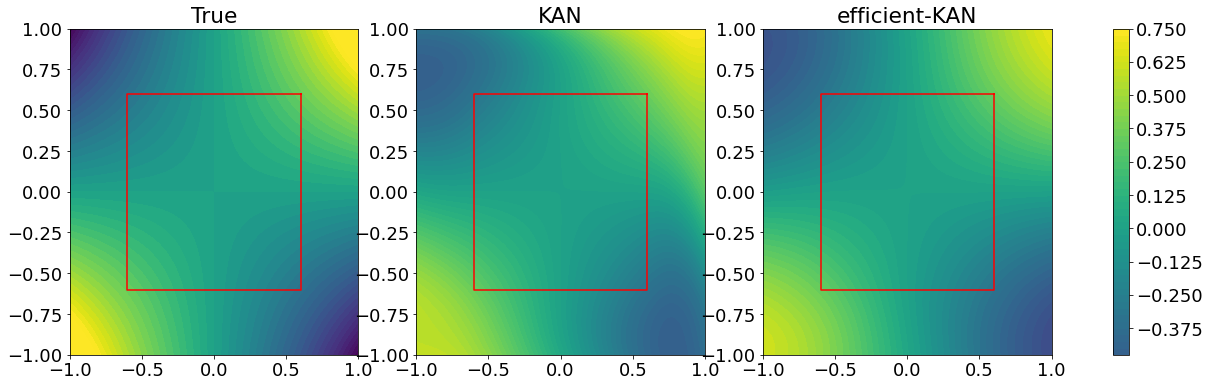

In [23]:
ranges_test=(-1, 1)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 5.f=1/(1+a*b)

In [24]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: 1/(1+x[:, [0]]*x[:, [1]])
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [25]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 1, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 6.48e-01 | test loss: 9.92e-01 | reg: 2.45e+00 : 100%|██| 20/20 [00:06<00:00,  3.00it/s]


In [26]:
# initialize efficientKAN #
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:23<00:00,  1.70it/s, mse_train_loss=0.114, reg_loss=6.14, test_loss=0.791


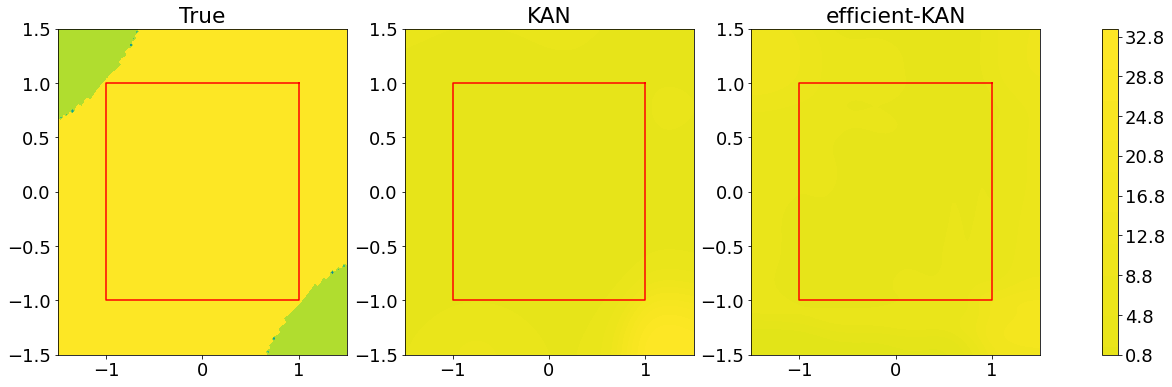

In [27]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 6.sin(a*b/2)^2)/(sin(b/2)^2)

In [28]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: (torch.sin(x[:, [0]]*x[:, [1]]/2)**2)/(torch.sin(x[:, [1]]/2)**2)
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [29]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 4, 3, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 1.81e-03 | test loss: 1.91e-03 | reg: 1.63e+01 : 100%|██| 20/20 [00:19<00:00,  1.05it/s]


In [30]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:22<00:00,  1.79it/s, mse_train_loss=9.14e-6, reg_loss=0.915, test_loss=9.


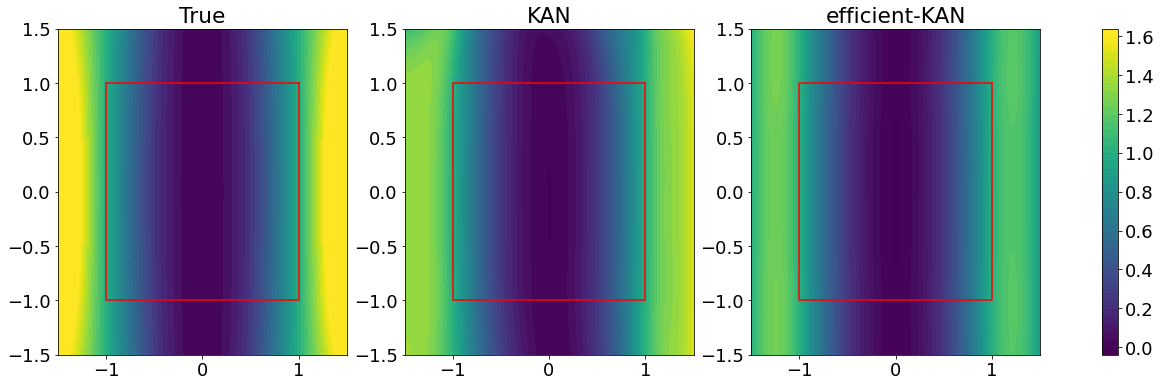

In [31]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 7. f=arcsin(a/b)

In [32]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: torch.arcsin(x[:, [0]]/x[:, [1]])
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)
# 筛选符合定义域的data
ratios = dataset["train_input"][:, 0] / dataset["train_input"][:, 1]
indices = torch.where((ratios > -1) & (ratios < 1))[0]
dataset["train_input"] = dataset["train_input"][indices, :]
dataset["train_label"] = dataset["train_label"][indices, :]

ratios = dataset["test_input"][:, 0] / dataset["test_input"][:, 1]
indices = torch.where((ratios > -1) & (ratios < 1))[0]
dataset["test_input"] = dataset["test_input"][indices, :]
dataset["test_label"] = dataset["test_label"][indices, :]

In [33]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 1, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 2.68e-01 | test loss: 2.72e-01 | reg: 2.94e+00 : 100%|██| 20/20 [00:07<00:00,  2.79it/s]


In [34]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:24<00:00,  1.64it/s, mse_train_loss=0.00443, reg_loss=3.05, test_loss=0.0


tensor([   0,   99,  100,  ..., 9899, 9900, 9999])
[[ 0.         1.369449   1.2855629 ... -1.2855629 -1.369449   0.       ]
 [ 0.         0.         1.3673766 ... -1.3673766  0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.        -1.3673766 ...  1.3673766  0.         0.       ]
 [ 0.        -1.369449  -1.2855629 ...  1.2855629  1.369449   0.       ]]


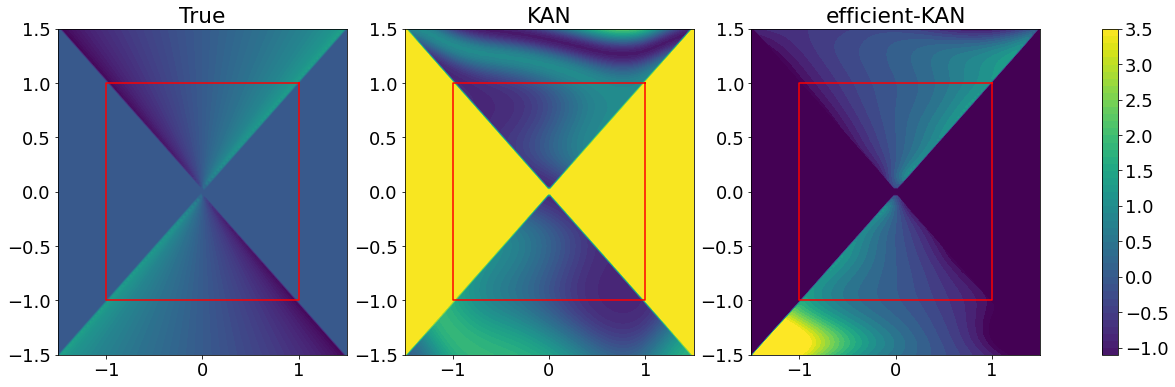

In [35]:
def figure_item(f, model_kan, model_efficient_kan, ranges_train=[-1, 1], ranges_test=(-1.5, 1.5)):
    x = np.linspace(ranges_test[0], ranges_test[1], 100)
    y = np.linspace(ranges_test[0], ranges_test[1], 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    
    ratios = grid_points_torch[:, 0] / grid_points_torch[:, 1]
    indices = torch.where((ratios <= -1) | (ratios >= 1))[0]
    print(indices)
    grid_points_torch[indices, 0] = 0
    grid_points_torch[indices, 1] = 2
    
    Z1 = f(grid_points_torch).numpy().reshape(X_grid.shape)
    print(Z1)
    Z2 = model_kan(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    Z3 = model_efficient_kan(grid_points_torch.to("cuda")).cpu().detach().numpy().reshape(X_grid.shape)
    square_vertices = [(ranges_train[1], ranges_train[1]), (ranges_train[0], ranges_train[1]), (ranges_train[0], ranges_train[0]), (ranges_train[1], ranges_train[0]), (ranges_train[1], ranges_train[1])]
    x_square, y_square = zip(*square_vertices)
    font_size = 18
    plt.rcParams['font.size'] = 18
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    contour1 = ax1.contourf(X_grid, Y_grid, Z1, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
    ax1.set_title('True')
    ax1.plot(x_square, y_square, 'r-')
    contour2 = ax2.contourf(X_grid, Y_grid, Z2, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
    ax2.set_title('KAN')
    ax2.plot(x_square, y_square, 'r-')
    contour3 = ax3.contourf(X_grid, Y_grid, Z3, levels=50, cmap='viridis', vmin=Z1.min(), vmax=Z2.max())
    ax3.set_title('efficient-KAN')
    ax3.plot(x_square, y_square, 'r-')
    cbar = fig.colorbar(contour2, ax=[ax1, ax2, ax3], location='right', shrink=1)
    plt.show()
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure_item(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 8. f=1+a+2*sqrt(a)*cos(b)

In [36]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: 1 + x[:, [0]] + 2 * torch.sqrt(x[:, [0]])*torch.cos(x[:, [1]])
# define Training data range
ranges_train = (0, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [37]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 2, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 3.30e-03 | test loss: 3.73e-03 | reg: 9.49e+00 : 100%|██| 20/20 [00:10<00:00,  1.90it/s]


In [41]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:22<00:00,  1.76it/s, mse_train_loss=0.000239, reg_loss=1.24, test_loss=0.


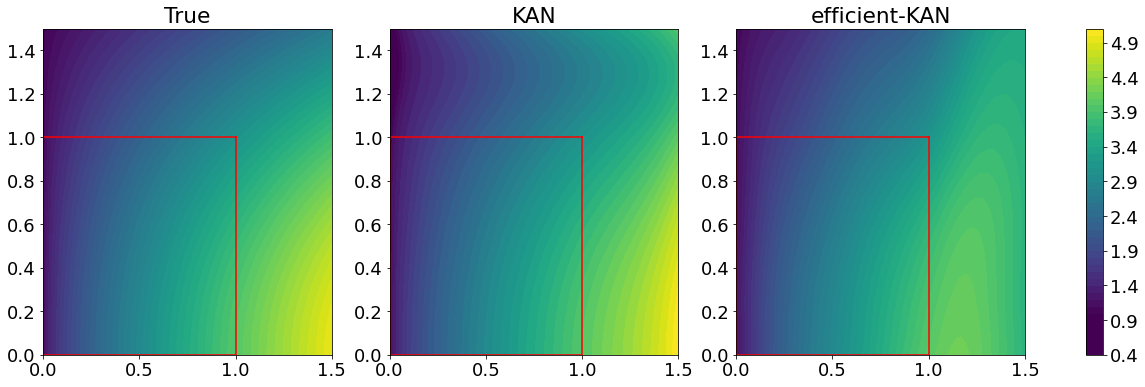

In [42]:
ranges_test=(0, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 9. f=a*ln(b)

In [43]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x:  x[:, [0]]*torch.log(x[:, [1]])
# define Training data range
ranges_train = (0, 6)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [44]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 2, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 4.33e-01 | test loss: 3.91e-01 | reg: 1.42e+01 : 100%|██| 20/20 [00:09<00:00,  2.09it/s]


In [45]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:23<00:00,  1.68it/s, mse_train_loss=0.107, reg_loss=6.25, test_loss=0.098


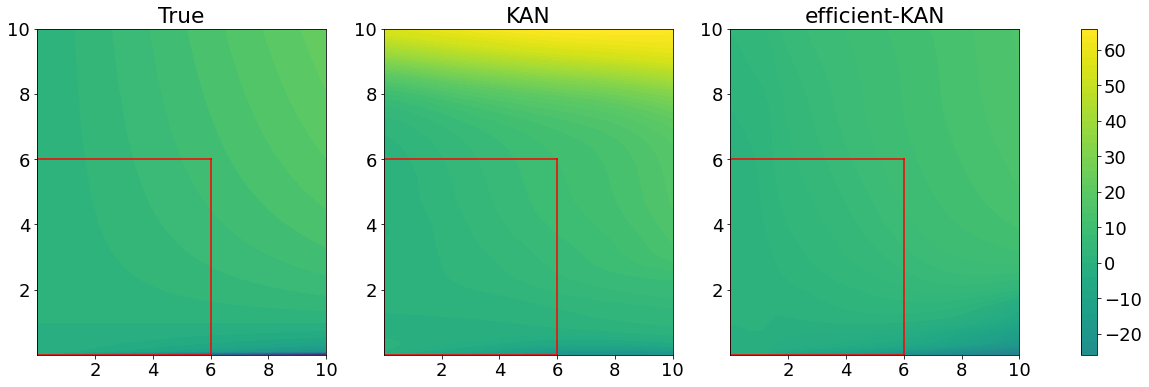

In [46]:
ranges_test=(0.00001, 10)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 10. f=cos(a) + b*cos(a)^2

In [47]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x: torch.cos(x[:, [0]]) +  x[:, [1]] *torch.cos(x[:, [0]])**2
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [48]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 3, 1], grid=3, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 1.18e-03 | test loss: 1.28e-03 | reg: 1.03e+01 : 100%|██| 20/20 [00:11<00:00,  1.79it/s]


In [49]:
# initialize efficientKAN # 
model_efficient_kan = EfficientKAN([2, 3, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:23<00:00,  1.68it/s, mse_train_loss=1.8e-5, reg_loss=1.18, test_loss=1.87


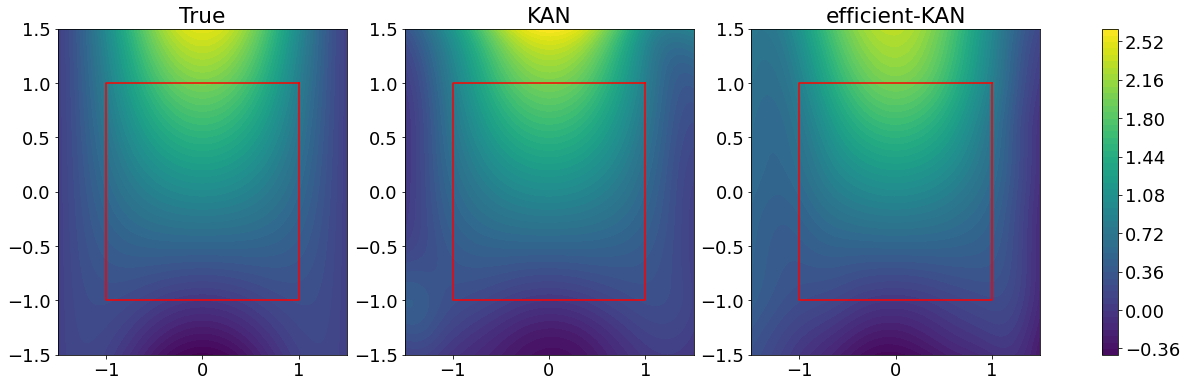

In [50]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

# 11. f=a/b

In [51]:
# create dataset   x[:, [0]]   x[:, [1]]
f = lambda x:  x[:, [0]] / x[:, [1]]
# define Training data range
ranges_train = (-1, 1)
dataset = create_dataset(f, n_var=2, ranges=ranges_train)

In [52]:
# initialize KAN with G=3
model_kan = KAN(width=[2, 1, 1], grid=5, k=3)
result = model_kan.train(dataset, opt="LBFGS", steps=20)

train loss: 6.10e+01 | test loss: 4.21e+01 | reg: 4.25e+01 : 100%|██| 20/20 [00:08<00:00,  2.23it/s]


In [59]:
# initialize efficientKAN # always NAN
model_efficient_kan = EfficientKAN([2, 2, 1], base_activation=nn.Identity).to('cuda')
optimizer = torch.optim.LBFGS(model_efficient_kan.parameters(), lr=0.05)
# optimizer = torch.optim.AdamW(model_efficient_kan.parameters(), lr=1e-3, weight_decay=1e-4)  # 都可以运行，需要修改train里面的迭代次数
train_efficient_kan(dataset, model_efficient_kan)

100%|█| 40/40 [00:24<00:00,  1.67it/s, mse_train_loss=769, reg_loss=44.8, test_loss=8.03e+3


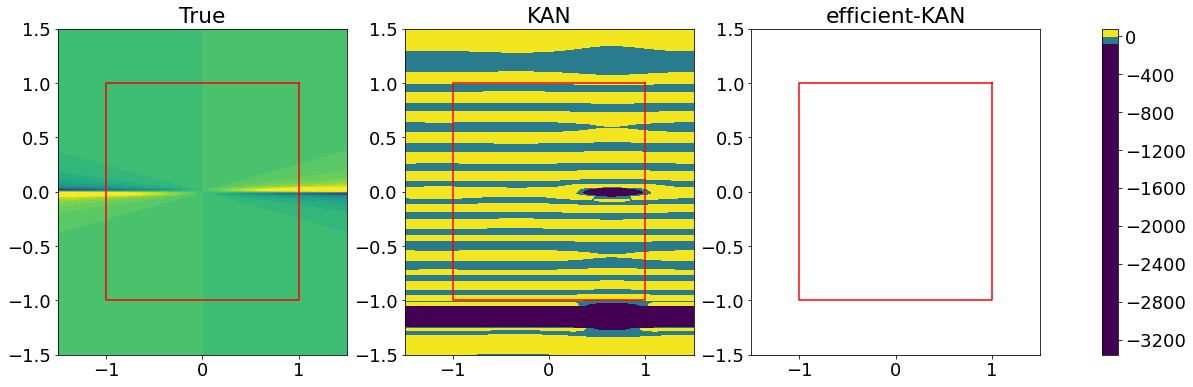

In [58]:
ranges_test=(-1.5, 1.5)  # (-2, 2) (-3, 3) 
figure(f, model_kan, model_efficient_kan, ranges_train=ranges_train, ranges_test=ranges_test)

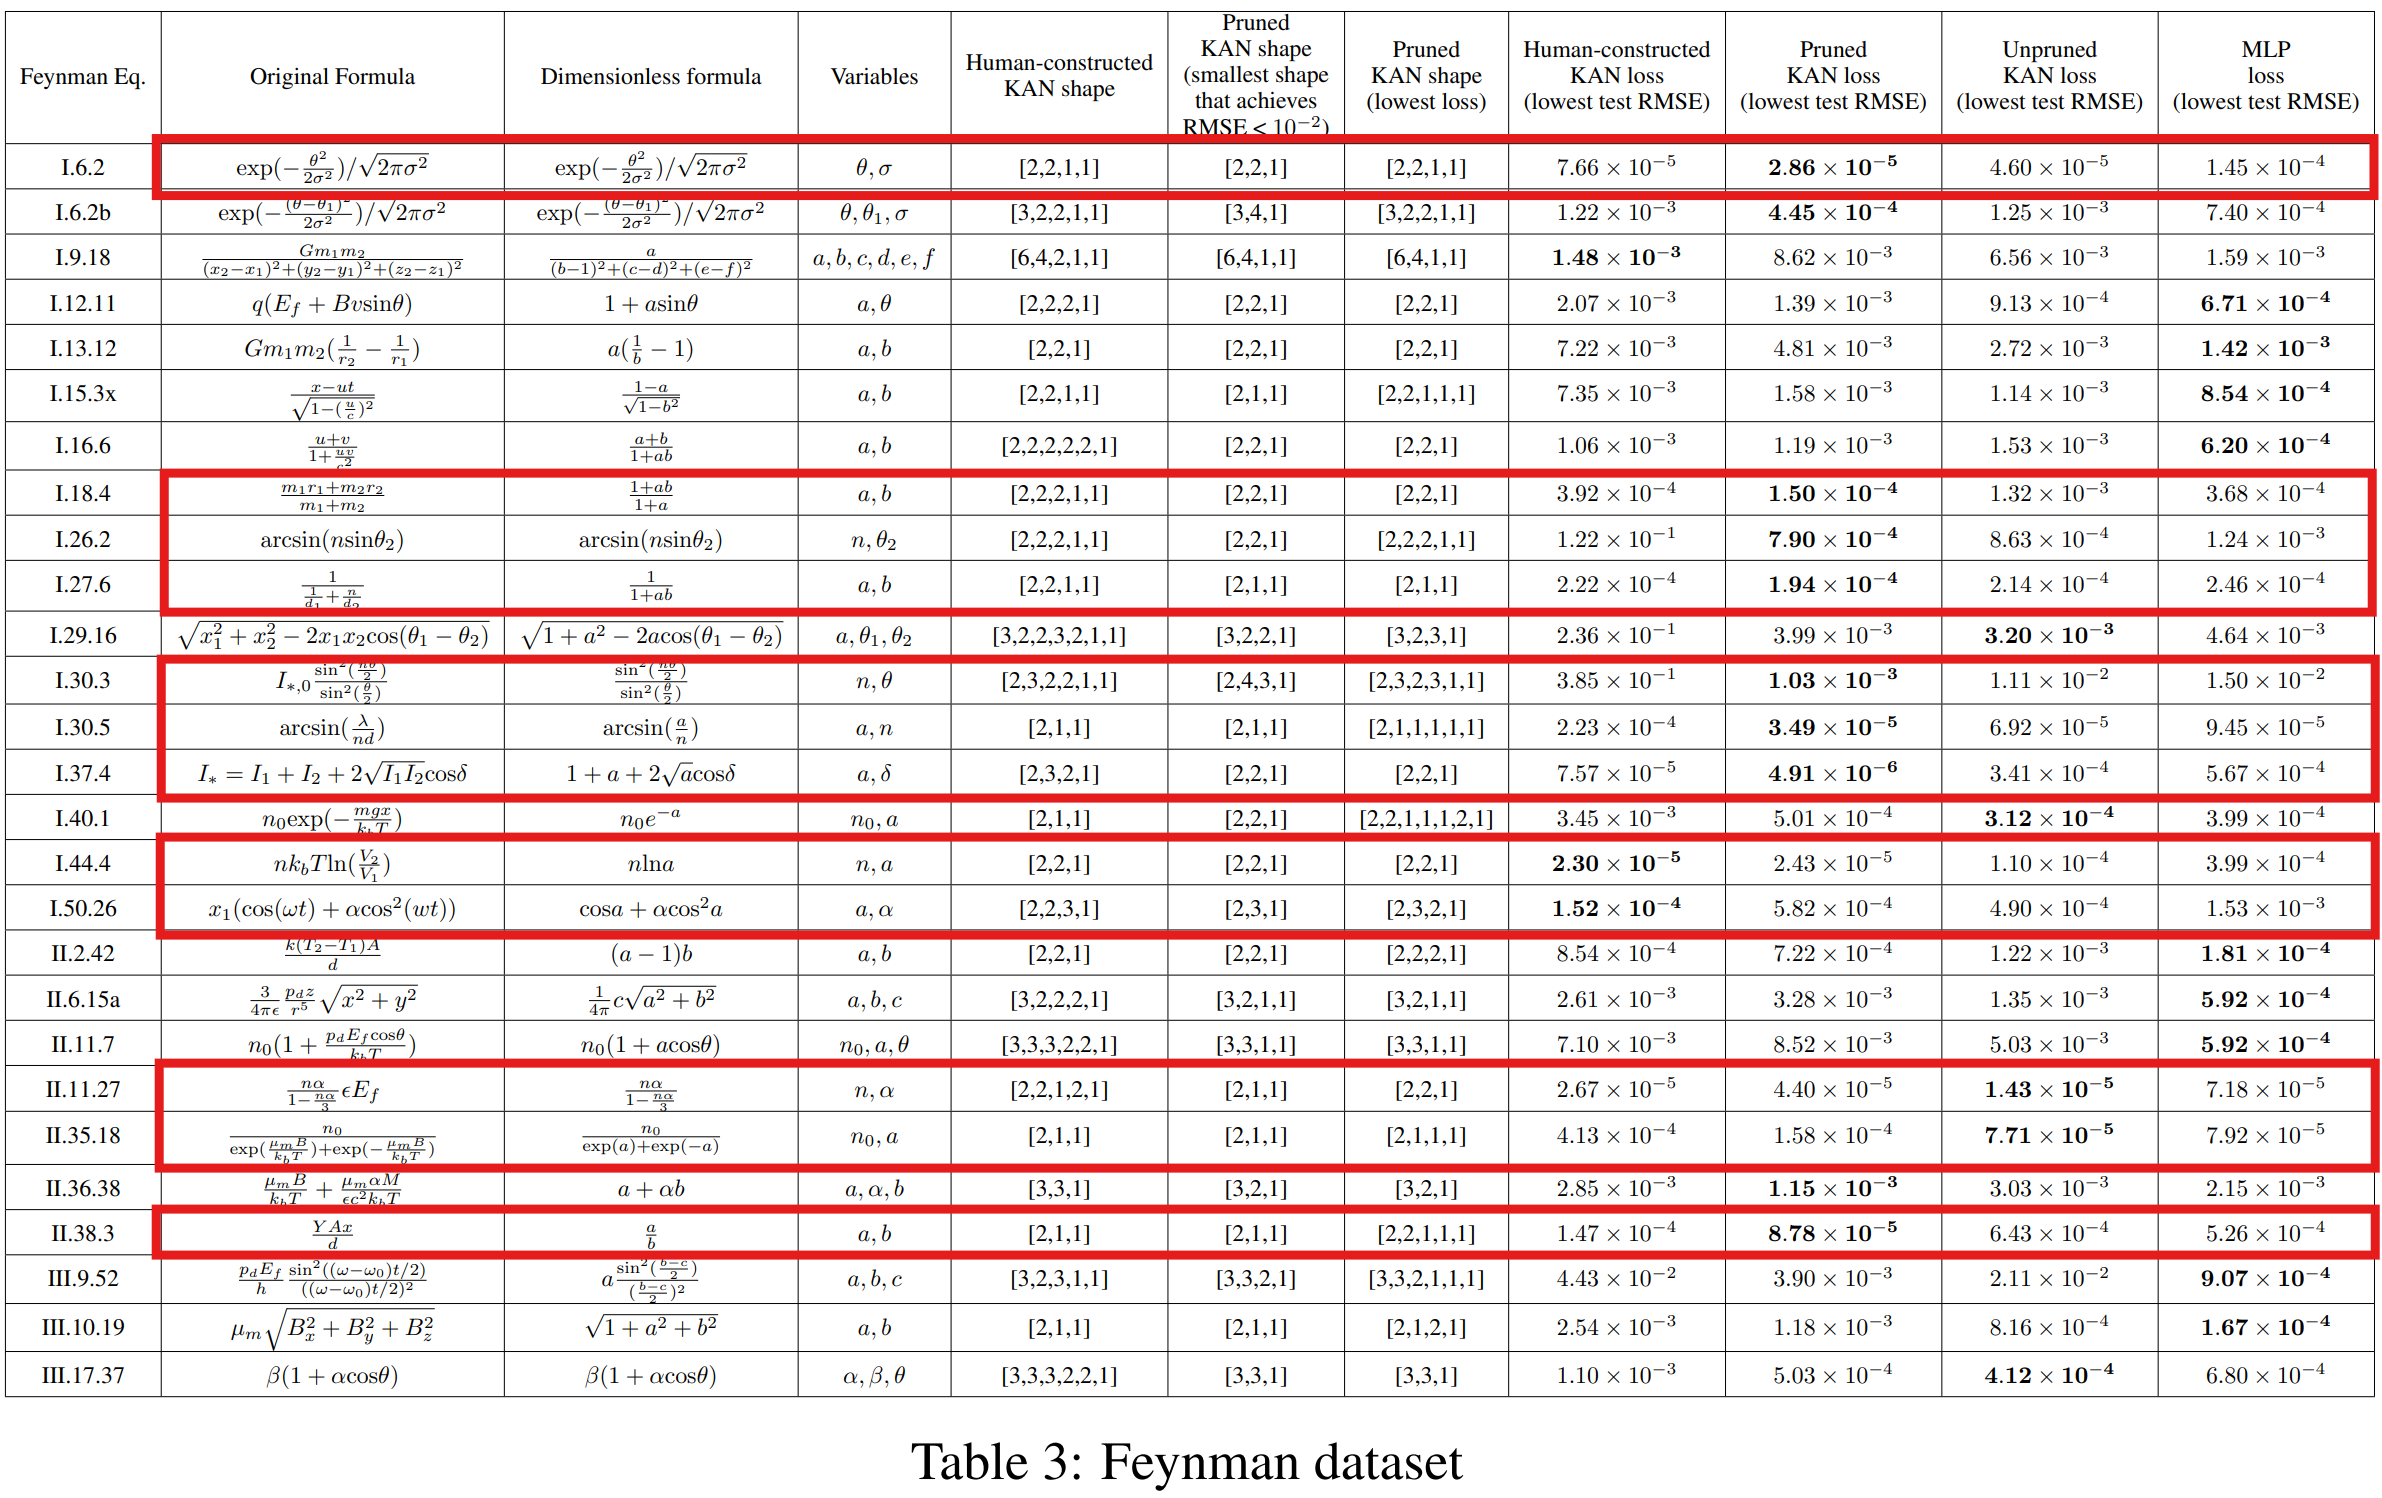